# News Pipeline Data Visualization

This notebook explores and visualizes the AI & Marketing news data stored in DuckDB.

## Overview
- **Database**: `data/news.duckdb`
- **Schemas**: `raw`, `processed`, `final`
- **Purpose**: Analyze article trends, sources, and data quality

In [6]:
# Import required libraries
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime, timedelta

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


## 1. Database Connection

Connect to the DuckDB database and explore available tables.

In [7]:
# Connect to DuckDB database
db_path = Path("../data/news.duckdb")

if not db_path.exists():
    print(f"❌ Database not found at {db_path}")
    print("Run the Dagster pipeline first to create data.")
else:
    conn = duckdb.connect(str(db_path))
    print(f"✅ Connected to database: {db_path}")
    
    # List all tables
    tables = conn.execute("""
        SELECT table_schema, table_name 
        FROM information_schema.tables 
        WHERE table_schema IN ('raw', 'processed', 'final')
        ORDER BY table_schema, table_name
    """).fetchdf()
    
    print("\n📊 Available tables:")
    print(tables.to_string(index=False))

✅ Connected to database: ..\data\news.duckdb

📊 Available tables:
table_schema            table_name
         raw ai_marketing_news_raw
         raw         filtered_news
         raw        processed_news


## 2. Data Overview

Get a quick overview of the data in each stage of the pipeline.

In [8]:
# Load data from each stage
raw_df = conn.execute("SELECT * FROM raw.ai_marketing_news_raw").fetchdf()
processed_df = conn.execute("SELECT * FROM raw.processed_news").fetchdf()
final_df = conn.execute("SELECT * FROM raw.filtered_news").fetchdf()

# Display summary statistics
print("📈 Pipeline Stage Summary")
print("=" * 60)
print(f"Raw Articles:       {len(raw_df):,} rows")
print(f"Processed Articles: {len(processed_df):,} rows (after deduplication)")
print(f"Final Articles:     {len(final_df):,} rows (after filtering)")
print(f"\nDuplicates Removed: {len(raw_df) - len(processed_df):,}")
print(f"Invalid Removed:    {len(processed_df) - len(final_df):,}")
print(f"Overall Retention:  {len(final_df)/len(raw_df)*100:.1f}%" if len(raw_df) > 0 else "N/A")

📈 Pipeline Stage Summary
Raw Articles:       16 rows
Processed Articles: 16 rows (after deduplication)
Final Articles:     16 rows (after filtering)

Duplicates Removed: 0
Invalid Removed:    0
Overall Retention:  100.0%


In [9]:
# Display sample data from final stage
print("\n📰 Sample Articles (Final Stage):")
print("=" * 60)
final_df[['title', 'source_name', 'publishedAt']].head(5)


📰 Sample Articles (Final Stage):


,title,source_name,publishedAt
0,Airbnb is 'an increasingly attractive brand mo...,StreetInsider.com,2025-12-17 15:10:14+01:00
1,"NexStrat AI, the First Enterprise-Grade AI Man...",StreetInsider.com,2025-12-17 15:10:12+01:00
2,Airbnb is 'an increasingly attractive brand mo...,Investing.com India,2025-12-17 14:57:20+01:00
3,2025's Top Crypto Presales Ranked by Growth: I...,FinanceFeeds,2025-12-17 14:45:53+01:00
4,"geoSurge Emerges From Stealth to Solve the ""Di...",StreetInsider.com,2025-12-17 14:35:22+01:00


## 3. Time Series Analysis

Visualize article publication trends over time.

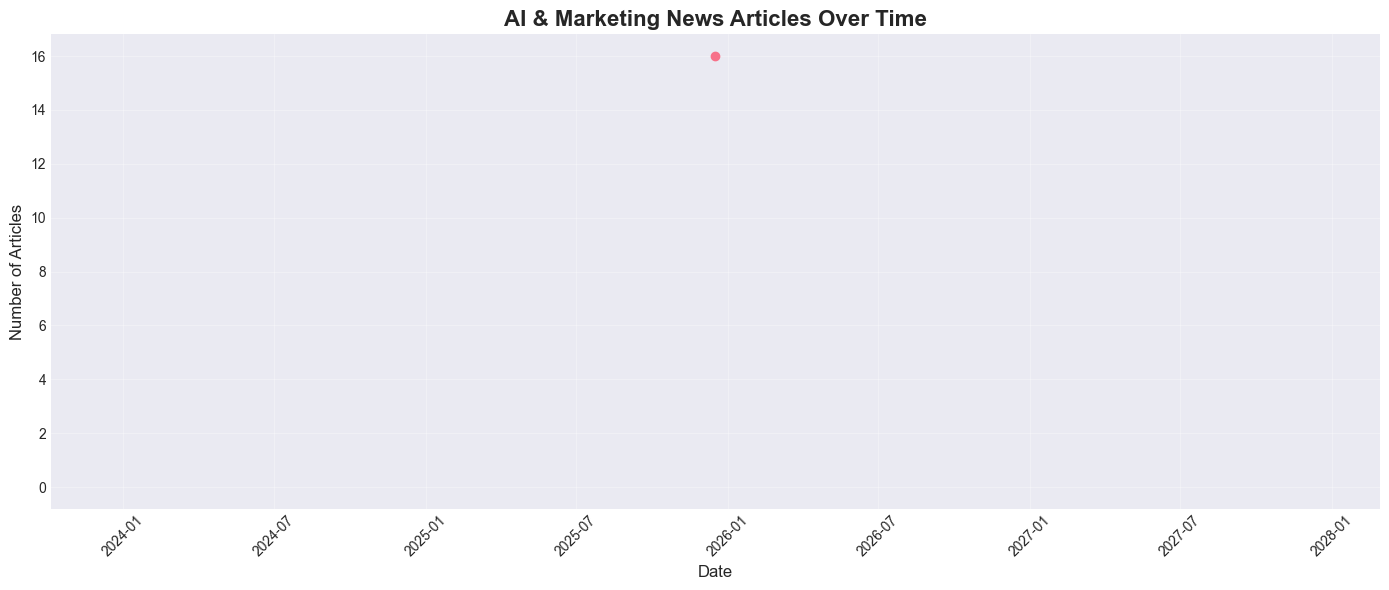

📅 Date Range: 2025-12-17 to 2025-12-17
📊 Average articles per day: 16.0


In [13]:
# Prepare time series data
final_df['publishedAt'] = pd.to_datetime(final_df['publishedAt'])
final_df['date'] = final_df['publishedAt'].dt.date

# Count articles per day
daily_counts = final_df.groupby('date').size().reset_index(name='count')
daily_counts['date'] = pd.to_datetime(daily_counts['date'])

# Create time series plot
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(daily_counts['date'], daily_counts['count'], marker='o', linewidth=2, markersize=6)
ax.fill_between(daily_counts['date'], daily_counts['count'], alpha=0.3)

ax.set_title('AI & Marketing News Articles Over Time', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Number of Articles', fontsize=12)
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"📅 Date Range: {daily_counts['date'].min().date()} to {daily_counts['date'].max().date()}")
print(f"📊 Average articles per day: {daily_counts['count'].mean():.1f}")

## 4. Top News Sources

Analyze which sources publish the most AI & Marketing content.

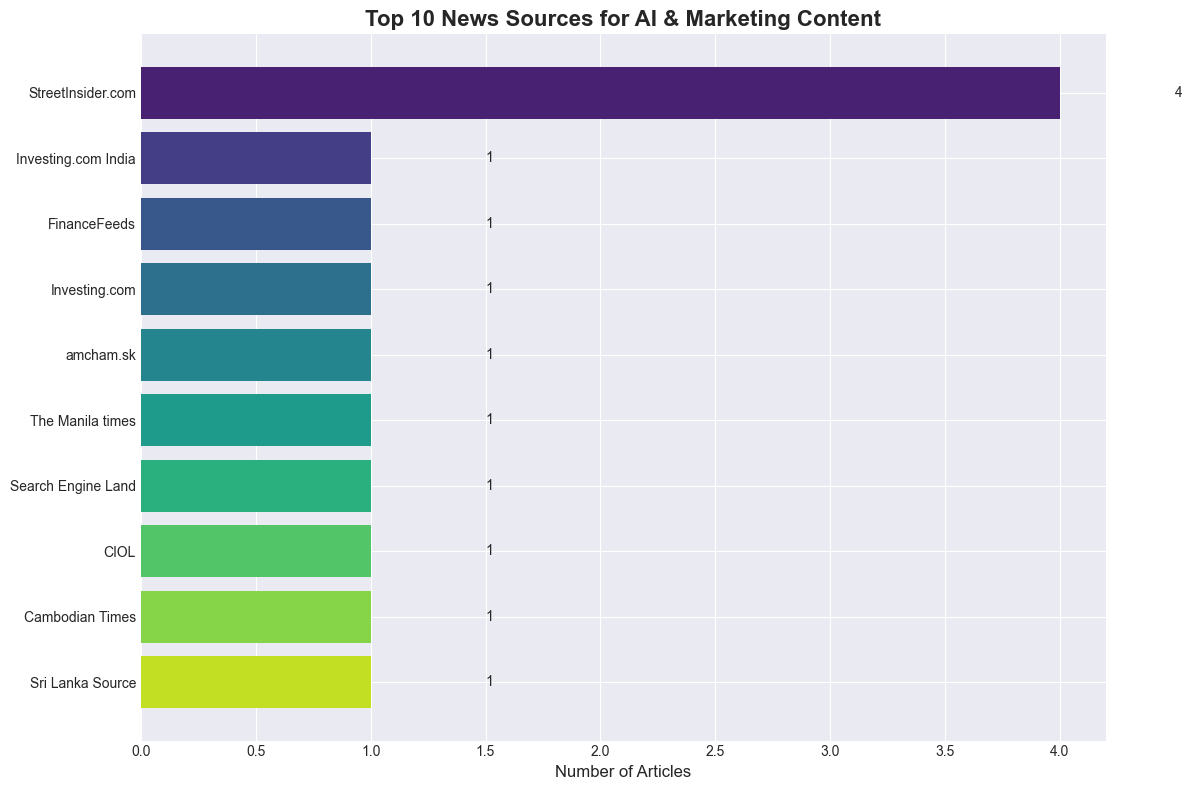


🏆 Top Source: StreetInsider.com (4 articles)


In [14]:
# Count articles by source
source_counts = final_df['source_name'].value_counts().head(10)

# Create horizontal bar chart
fig, ax = plt.subplots(figsize=(12, 8))
colors = sns.color_palette("viridis", len(source_counts))
bars = ax.barh(range(len(source_counts)), source_counts.values, color=colors)

ax.set_yticks(range(len(source_counts)))
ax.set_yticklabels(source_counts.index)
ax.set_xlabel('Number of Articles', fontsize=12)
ax.set_title('Top 10 News Sources for AI & Marketing Content', fontsize=16, fontweight='bold')
ax.invert_yaxis()

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, source_counts.values)):
    ax.text(value + 0.5, i, str(value), va='center', fontsize=10)

plt.tight_layout()
plt.show()

print(f"\n🏆 Top Source: {source_counts.index[0]} ({source_counts.values[0]} articles)")

## 5. Publication Time Analysis

Analyze when articles are typically published (hour of day).

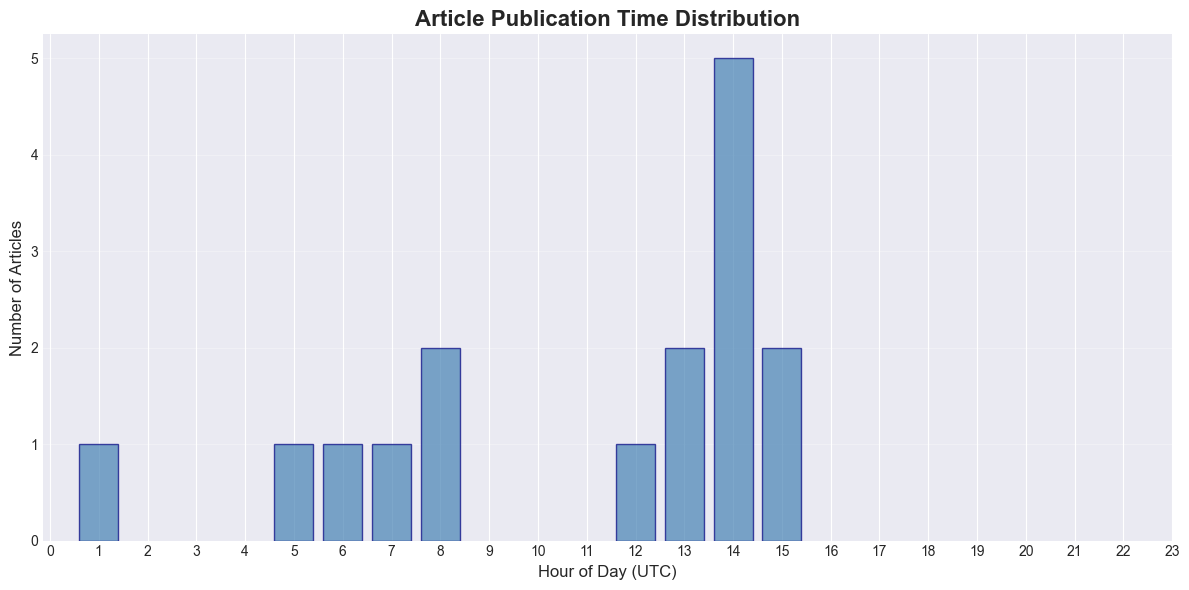

⏰ Peak publication hour: 14:00 UTC (5 articles)
📊 Most articles published between [14, 8, 13] UTC


In [17]:
# Extract hour from timestamp
final_df['hour'] = final_df['publishedAt'].dt.hour
hourly_counts = final_df['hour'].value_counts().sort_index()

# Create circular/radial bar chart effect
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(hourly_counts.index, hourly_counts.values, color='steelblue', alpha=0.7, edgecolor='navy')

# Highlight peak hours
peak_hour = hourly_counts.idxmax()
# bars[peak_hour].set_color('coral')
# bars[peak_hour].set_alpha(1.0)

ax.set_xlabel('Hour of Day (UTC)', fontsize=12)
ax.set_ylabel('Number of Articles', fontsize=12)
ax.set_title('Article Publication Time Distribution', fontsize=16, fontweight='bold')
ax.set_xticks(range(0, 24))
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"⏰ Peak publication hour: {peak_hour}:00 UTC ({hourly_counts.max()} articles)")
print(f"📊 Most articles published between {hourly_counts.nlargest(3).index.tolist()} UTC")